In [2]:
import logging
import json
import random
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import time
import numpy as np
import sys
from models.baseline_snli import encoder
from models.baseline_snli import LSTMTagger
import argparse
from models.snli_data import snli_data
from models.snli_data import w2v
from torch import autograd

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

No handlers could be found for logger "mylog"


In [3]:
def get_errors(dev_lbl_batch,pred):
    error_list=[]
    for i,v in enumerate(dev_lbl_batch.data.numpy()):
        if v != pred[i]:
            error_list.append((i,'Actual: '+labels_mapping[v]+', Predicted: '+labels_mapping[pred[i]]))
        else:
            error_list.append((i,'Correct'))
    return error_list


def update_error_analysis_dict(actual_labels, pred_labels):
    for i in range (len(actual_labels)):
        error_analysis[labels_mapping[actual_labels[i]]][labels_mapping[pred_labels[i]]] += 1

def print_sentence(batch,idx,return_result=True):
    premise = []
    hypothesis = []
    s = dev_batches[batch]
    for pword in s[0][idx]:
        premise.append(idx_to_word[pword])
    for hword in s[1][idx]:
        hypothesis.append(idx_to_word[hword])
    if return_result is True:
        return 'Premise: '+' '.join(premise)+'\nHypothesis: '+' '.join(hypothesis)+'\n'+outcomes[batch][1][idx][1]
    else:
        return 'Premise: '+' '.join(premise)+'\nHypothesis: '+' '.join(hypothesis)

def heatmap(batch,idx):
    batch_num = batch
    item_in_batch = idx
    hypothesis_words = []
    premise_words = []
    for i in dev_batches[batch_num][0][item_in_batch]:
        premise_words.append(idx_to_word[i])
    for i in dev_batches[batch_num][1][item_in_batch]:
        hypothesis_words.append(idx_to_word[i])
    df = pd.DataFrame(alphas[batch_num][item_in_batch].data.numpy(), index=premise_words).transpose()
    fig, ax = plt.subplots(figsize=(10,1))     
    sns.heatmap(df, cmap="YlGnBu")
    ax.get_yaxis().set_visible(False)
    plt.title('hypothesis: %s'%(' '.join(word for word in hypothesis_words)))
    print(print_sentence(batch_num,item_in_batch))
    plt.show()

'''
Error Analysis
'''
from collections import defaultdict

labels_mapping = {1:'neutral', 0:'entailment', 2:'contradiction'}
error_analysis = defaultdict(dict)
labels = ['neutral', 'entailment', 'contradiction']

for i in labels_mapping.values():
    for j in labels:
        error_analysis[i][j] = 0

# Load Files

In [4]:
mypath='/Users/Lisa/Documents/Grad School/DS-GA 1101/data/'

In [5]:
#Load validation set
w2v_file = mypath+"snli_preprocess/glove.hdf5"

word_vecs = w2v(w2v_file).word_vecs 
dev_file = mypath+"snli_preprocess/val.hdf5"

dev_data = snli_data(dev_file, -1)
dev_batches = dev_data.batches

In [6]:
#Load index to word dictionary
word_dict_path = mypath+'snli_preprocess/word.dict'
idx_to_word = {}
with open(word_dict_path,'r') as inf:
    for line in inf:
        line = line.split()
        idx_to_word[int(line[1])] = line[0]
'''change to 0 indexing'''
idx_to_word = {k-1:v for k,v in idx_to_word.items()}

In [7]:
#Load Model
encode_model_fp = '/Users/Lisa/Documents/Grad School/DS-GA 1101/nlp_project/wbw/output/01_epoch-9_dev-acc-0.715_input-encoder.pt'
atten_model_fp = '/Users/Lisa/Documents/Grad School/DS-GA 1101/nlp_project/wbw/output/01_epoch-9_dev-acc-0.715_lstm.pt'
embedding_size = 300
hidden_size = 150
train_lbl_size = 3
para_init = 0.01

#init
input_encoder = encoder(word_vecs.size(0), embedding_size, hidden_size, para_init)
inter_atten = LSTMTagger(hidden_size, train_lbl_size)

#load state (map_location converts model from gpu to cpu)
input_encoder.load_state_dict(torch.load(encode_model_fp, map_location=lambda storage, loc: storage))
inter_atten.load_state_dict(torch.load(atten_model_fp, map_location=lambda storage, loc: storage))

# Eval Dev Set

In [8]:
'''
Evaluate model on the dev set.
This may take a few minutes to run.
'''

input_encoder.eval()
inter_atten.eval()
correct = 0.
total = 0.
predicted_lbls = []
alphas = []
outcomes = []

for i in range(len(dev_batches)):
    dev_src_batch, dev_tgt_batch, dev_lbl_batch = dev_batches[i]
    dev_src_batch = Variable(dev_src_batch)
    dev_tgt_batch = Variable(dev_tgt_batch)
    dev_lbl_batch = Variable(dev_lbl_batch)

    dev_src_linear, dev_tgt_linear=input_encoder(
        dev_src_batch, dev_tgt_batch)
    log_prob, alpha=inter_atten(dev_src_linear, dev_tgt_linear, return_attn=True)

    _, predict=log_prob.data.max(dim=1)
    total += dev_lbl_batch.data.size()[0]
    correct += torch.sum(predict == dev_lbl_batch.data)
    update_error_analysis_dict(dev_lbl_batch.data, predict)
    predicted_lbls.append(predict)
    alphas.append(alpha)
    results = get_errors(dev_lbl_batch,predict)
    outcomes.append((i,results))

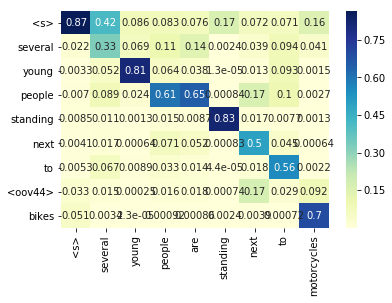

In [59]:

import numpy as np
import pandas as pd
import seaborn as sns
batch_num = 100
item_in_batch = 0
hypothesis_words = []
premise_words = []
for i in dev_batches[batch_num][0][item_in_batch]:
    premise_words.append(idx_to_word[i])
for i in dev_batches[batch_num][1][item_in_batch]:
    hypothesis_words.append(idx_to_word[i])
df = pd.DataFrame(alphas[batch_num][:,item_in_batch].data.numpy().T, columns=hypothesis_words, index=premise_words)
sns.heatmap(df, cmap="YlGnBu", annot=True)
plt.show()

In [26]:
print_sentence(748,0,return_result=True)

'Premise: <s> the strangely dressed guys , one wearing an orange wig , sunglasses with peace signs , and a karate costume with an <oov2> belt , another wearing a curly blue wig , heart shaped sunglasses , and a karate outfit painted with leaves , and the third wearing pink underwear , a black afro , and giant sunglasses\nHypothesis: <s> there are people wearing outfits\nCorrect'

In [29]:
dev_batches[748][0]



Columns 0 to 10 
     2   9172  16486  15673  11298   4330    640   8504   7936  14037  17467

Columns 11 to 21 
  4330  12793    854   6564   1004   4330  27771  24204  23876   3134    854

Columns 22 to 32 
  7936  20304   1166   4330   1913   8504  24204  23810   5255  17467   4330

Columns 33 to 43 
 16622  20959  12793   4330  27771  24204  23876  10551  14190    854   5278

Columns 44 to 54 
  4330  27771   9172   3555   8504  10343  11369   4330  24204  11448  10137

Columns 55 to 58 
  4330  27771  26132  12793
[torch.LongTensor of size 1x59]

In [56]:
alphas[300][:,0].data.numpy().shape

(11, 15)

In [53]:
dev_batches[300][0][0]


     2
 18620
 15653
 22908
 24204
 10396
 25650
   854
  9172
 18051
 11045
  8961
 19496
  9172
 28602
[torch.LongTensor of size 15]

In [54]:
dev_batches[300][1][0]


     2
  1922
 27999
 20623
 22908
 24204
 25650
 22908
 24204
  1128
  3844
[torch.LongTensor of size 11]